# 快速傅里叶变换

## 频率域的信息

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.style.use(['ggplot','../../presentation.mplstyle'])

构造带有两个频率的信号

In [4]:
# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)

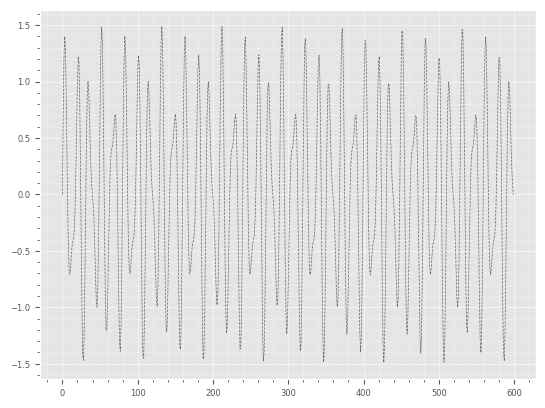

In [5]:
from plot.qiplot import plot_ts

t=[x for x in range(len(y))]
fig,ax=plt.subplots()
plot_ts(ax,t,y)

傅里叶变换

In [6]:
yf = np.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

展示频率域信息，可以清楚地看到两个频率信息。

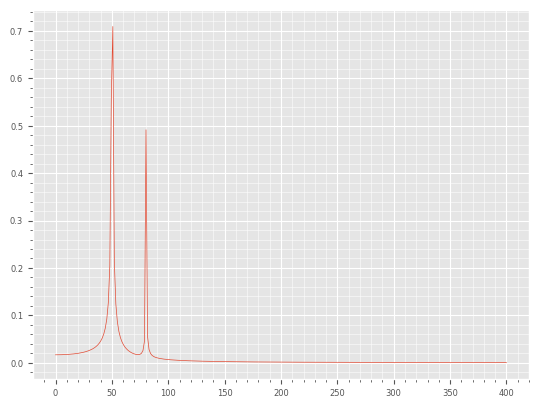

In [7]:
fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
ax.grid(zorder=0)
ax.grid(which='major', color='white', linestyle='-',alpha=1)
ax.grid(which='minor', color='white', linestyle='-',alpha=0.5)
plt.minorticks_on()
plt.show()

```{bibliography}
:filter: docname in docnames
```
